## create rasterized datasets

In [1]:
import pandas as pd
import numpy as np
import zarr

def in_cylinder(end_1, end_2, radius):
    # https://stackoverflow.com/questions/56463412/distance-from-a-point-to-a-line-segment-in-3d-python
    # normalized tangent vector
    d = np.divide(end_2 - end_1, np.linalg.norm(end_2 - end_1))

    # possible points
    mins = np.floor(np.minimum(end_1,end_2)).astype(int)-(radius+1) #1s for padding
    maxs = np.ceil(np.maximum(end_1,end_2)).astype(int) +(radius+1)
    
    x,y,z = [list(range(mins[i],maxs[i]+1,1)) for i in range(3)]
    p = np.array(np.meshgrid(x, y,z)).T.reshape((-1,3))

    # signed parallel distance components
    s = np.dot(end_1 - p, d)
    t = np.dot(p - end_2, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros_like(s)])

    # perpendicular distance component
    c = np.linalg.norm(np.cross(p - end_1, d),axis=1)
    
    is_in_cylinder = (h==0) & (c<=radius)
    return set(map(tuple, p[is_in_cylinder]))

zarr_file = zarr.open(f"/nrs/stern/em_data/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5", mode="r")
dataset = "em/fibsem-uint8/s0"
resolution = np.array(zarr_file[dataset].attrs.asdict()["transform"]["scale"])
# https://cell-map.slack.com/archives/C04N9JUFQK1/p1683733456153269
df = pd.read_csv("annotations_20230510_114340.csv")
pd_starts = np.array([df["start x (nm)"], df["start y (nm)"], df["start z (nm)"]]).T/resolution
pd_ends = np.array([df["end x (nm)"], df["end y (nm)"], df["end z (nm)"]]).T/resolution
pd_centers = list(map(tuple,np.round(((pd_starts+pd_ends)*resolution/2)).astype(int)))

# densely annotated validation region:
offset = np.array([27400, 2000, 5300])
dimensions = np.array([300, 200, 200])


now that we can find which points are in cylinder, we can do this for all annotations and concatenate, then we can write out the n5 file

In [2]:

from tqdm import tqdm
from numcodecs.gzip import GZip
import zarr

# get all pd voxels and all overlapping/intersecting voxels between multiple pd
all_pd_voxels_set = set()
intersection_voxels_set = set()
for pd_start,pd_end in tqdm(zip(pd_starts,pd_ends),total=len(pd_starts)):
    voxels_in_cylinder = in_cylinder(pd_start,pd_end,radius=4)
    intersection_voxels_set.update(all_pd_voxels_set.intersection(voxels_in_cylinder))
    all_pd_voxels_set.update(voxels_in_cylinder)

# # repeat but now will write out the relevant voxels with appropriate id
# store = zarr.N5Store("/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5")
# zarr_root = zarr.group(store=store)
# ds = zarr_root.create_dataset(
#         overwrite=True,
#         name="plasmodesmata_as_cylinders",
#         dtype='u2',
#         shape=zarr_file[dataset].shape,
#         chunks=128,
#         write_empty_chunks=False,
#         compressor=GZip(level=6),
#     )
# attributes = ds.attrs
# attributes["pixelResolution"] = {
#     "dimensions": 3 * [8],
#     "unit": "nm",
# }

# pd_id = 1
# all_pd_voxels_set -= intersection_voxels_set
# for pd_start,pd_end in tqdm(zip(pd_starts,pd_ends),total=len(pd_starts)):
#     voxels_in_cylinder = in_cylinder(pd_start,pd_end,radius=4) - intersection_voxels_set
#     if len(voxels_in_cylinder)>0:
#         voxels_in_cylinder = np.array(list(voxels_in_cylinder))
#         ds[voxels_in_cylinder[:,2],voxels_in_cylinder[:,1],voxels_in_cylinder[:,0]] = pd_id
#         pd_id +=1
#     else:
#         raise Exception(f"Empty plasmodesmata {pd_starts}-{pd_ends}")


100%|██████████| 1920/1920 [00:14<00:00, 133.42it/s]


mask where we set all intersection voxels to 0

In [69]:
import os
zarr_file = zarr.open(f"/nrs/stern/em_data/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5", mode="r")
zarr_path = "/nrs/cellmap/ackermand/cellmap/leaf-gall/masks.zarr"
if not os.path.exists(zarr_path):
    zarr_root = zarr.open(zarr_path, mode='w')
ds = zarr_root.create_dataset(
        overwrite=True,
        name="jrc_22ak351-leaf-3m",
        dtype='u1',
        fill_value = 1,
        shape=zarr_file[dataset].shape,
        chunks=128,
        write_empty_chunks=False,
        compressor=GZip(level=6),
    )
attributes = ds.attrs
attributes["pixelResolution"] = {
    "dimensions": 3 * [8],
    "unit": "nm",
}
intersection_voxels = np.array(list(intersection_voxels_set))
ds[intersection_voxels[:,2],intersection_voxels[:,1],intersection_voxels[:,0]] = 0



## validation crop

In [15]:
from numcodecs.gzip import GZip
zarr_file = zarr.open(f"/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5", mode="r")
plasmodesmata_as_cylinders = zarr_file["plasmodesmata_as_cylinders"]
validation_crop = plasmodesmata_as_cylinders[offset[2]:offset[2]+dimensions[2],
                                             offset[1]:offset[1]+dimensions[1],
                                             offset[0]:offset[0]+dimensions[0]]

store = zarr.N5Store("/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5")
zarr_root = zarr.group(store=store)
ds = zarr_root.create_dataset(
        overwrite=True,
        name="validation_crop",
        data=validation_crop,
        dtype='u2',
        chunks=128,
        write_empty_chunks=False,
        compressor=GZip(level=6),
    )
attributes = ds.attrs
attributes["pixelResolution"] = {
    "dimensions": 3 * [8],
    "unit": "nm",
}
attributes["offset"] = offset

get plasmodesmata that are not in validation crop

In [3]:
updated_pd_centers = []
for pd_start,pd_end,pd_center in tqdm(zip(pd_starts,pd_ends,pd_centers),total=len(pd_starts)):
    voxels_in_cylinder = in_cylinder(pd_start,pd_end,radius=4)
    voxels_in_cylinder = np.array(list(voxels_in_cylinder))
    if ~np.any([(voxels_in_cylinder[:,0]>=offset[0]) & (voxels_in_cylinder[:,0]<=offset[0]+dimensions[0])
                & (voxels_in_cylinder[:,1]>=offset[1]) & (voxels_in_cylinder[:,1]<=offset[1]+dimensions[1])
                & (voxels_in_cylinder[:,2]>=offset[2]) & (voxels_in_cylinder[:,2]<=offset[2]+dimensions[2])]):
        updated_pd_centers.append(pd_center)
len(updated_pd_centers),len(pd_centers)

100%|██████████| 1920/1920 [00:14<00:00, 132.59it/s]


(1878, 1920)

# Dacapo

In [4]:
from dacapo.experiments.architectures import CNNectomeUNetConfig
from dacapo.experiments.trainers import GunpowderTrainerConfig
from dacapo.experiments.trainers.gp_augments import ElasticAugmentConfig,IntensityAugmentConfig
from dacapo.experiments.tasks import AffinitiesTaskConfig
from funlib.geometry.coordinate import Coordinate
import math

/groups/scicompsoft/home/ackermand/miniconda3/envs/plasmodesmata_dacapo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Trainer

In [ ]:
trainer_config = GunpowderTrainerConfig(
        name="default_v2",
        batch_size=2,
        learning_rate=0.0001,
        augments=[
            ElasticAugmentConfig(
                control_point_spacing=(100, 100, 100),
                control_point_displacement_sigma=(10.0, 10.0, 10.0),
                rotation_interval=(0, math.pi / 2.0),
                subsample=8,
                uniform_3d_rotation=True,
            ),
            IntensityAugmentConfig(
                scale=(0.7, 1.3),
                shift=(-0.2, 0.2),
                clip=True,
            ),
        ],
        clip_raw=True,
        num_data_fetchers=20,
        snapshot_interval=10000,
        min_masked=0.05,
    )

## Task

In [ ]:
task_config = AffinitiesTaskConfig(
            name=f"3d_lsdaffs",
            neighborhood=[
                (1, 0, 0),
                (0, 1, 0),
                (0, 0, 1),
                (3, 0, 0),
                (0, 3, 0),
                (0, 0, 3),
                (9, 0, 0),
                (0, 9, 0),
                (0, 0, 9),
            ],
            lsds=True,
        )

## Architecture

In [ ]:
architecture_config = CNNectomeUNetConfig(
        name="upsample-unet",
        input_shape=Coordinate(216, 216, 216),
        eval_shape_increase=Coordinate(72, 72, 72),
        fmaps_in=1,
        num_fmaps=12,
        fmaps_out=72,
        fmap_inc_factor=6,
        downsample_factors=[(2, 2, 2), (3, 3, 3), (3, 3, 3)],
        constant_upsample=True,
        upsample_factors=[(2, 2, 2)],
    )

## Datasplit

In [ ]:
from pathlib import Path
from dacapo.experiments.datasplits.datasets.arrays import (
    ZarrArrayConfig,
    IntensitiesArrayConfig,
    CropArrayConfig,
)
from dacapo.experiments.datasplits.datasets import RawGTDatasetConfig
from dacapo.experiments.datasplits import TrainValidateDataSplitConfig
from funlib.geometry import Roi

raw_config = ZarrArrayConfig(
    name = "raw",
    file_name=Path("/nrs/stern/em_data/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5"),
    dataset="em/fibsem-uint8/s0",
)
# We get an error without this, and will suggests having it as such https://cell-map.slack.com/archives/D02KBQ990ER/p1683762491204909
raw_config = IntensitiesArrayConfig(name="raw", source_array_config = raw_config, min=0, max=255)

gt_config = ZarrArrayConfig(
    name="plasmodesmata", 
    file_name=Path("/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5"), 
    dataset="plasmodesmata_as_cylinders"
)

# mask out regions of overlapping plasmodesmata
mask_config = ZarrArrayConfig(
    name="mask", 
    file_name=Path("/nrs/cellmap/ackermand/cellmap/leaf-gall/masks.zarr"), 
    dataset="jrc_22ak351-leaf-3m"
)

# could do validation as a file
# val_gt_config = ZarrArrayConfig(
#     name="plasmodesmata", file_name="/path/to/data.zarr", dataset="labels_val"
# )
validation_roi = Roi(offset*resolution, dimensions*resolution)
val_gt_config = CropArrayConfig(
    "val_gt", source_array_config=gt_config, roi=validation_roi
)
training_data_config = RawGTDatasetConfig(
    "train",
    raw_config = raw_config,
    gt_config = gt_config,
    sample_points = [Coordinate(pd_center) for pd_center in updated_pd_centers], #[Coordinate((29229*8,1862*8,7439*8))], #[Coordinate(pd_center[::-1]) for pd_center in updated_pd_centers],
    mask_config = mask_config
)
validation_data_config = RawGTDatasetConfig("val", raw_config = raw_config, gt_config=val_gt_config, mask_config=mask_config)
datasplit_config = TrainValidateDataSplitConfig(
    name="plasmodesmata", train_configs=[training_data_config], validate_configs=[validation_data_config]
)

## Run

In [13]:
from dacapo.experiments import RunConfig
from dacapo.experiments.starts import StartConfig
from dacapo.store.create_store import create_config_store
config_store = create_config_store()

start_config = StartConfig("setup04", "best")
iterations = 2
validation_interval = 5000
for i in range(iterations):
    run_config = RunConfig(
        name=("_").join(
            [
                "scratch" if start_config is None else "finetuned",
                task_config.name,
                datasplit_config.name,
                architecture_config.name,
                trainer_config.name,
            ]
        )
        + f"__{i}",
        task_config=task_config,
        datasplit_config=datasplit_config,
        architecture_config=architecture_config,
        trainer_config=trainer_config,
        num_iterations=iterations,
        validation_interval=validation_interval,
        repetition=i,
        start_config=start_config,
    )
    config_store.store_run_config(run_config)
#"dacapo run -r {run_config.name}"

In [8]:
offset*8

array([219200,  16000,  42400])

In [21]:
run_config.name

'finetuned_3d_lsdaffs_plasmodesmata_upsample-unet_default_v2__1'

## Visualize run before train: https://github.com/janelia-cellmap/ml_experiments/blob/main/scripts/visualize_pipeline.py
creates a neuroglancer view, of your training samples. hitting "t" refreshes to a new example

python ~/Programming/ml_experiments/scripts/visualize_pipeline.py visualize-pipeline -r finetuned_3d_lsdaffs_plasmodesmata_upsample-unet_default_v2__1

In [27]:
from numcodecs.gzip import GZip
import zarr

store = zarr.N5Store("./test.n5")
zarr_root = zarr.group(store=store)
ds = zarr_root.create_dataset(
        overwrite=True,
        name="test",
        dtype='u1',
        shape=zarr_file[dataset].shape,
        chunks=128,
        write_empty_chunks=False,
        compressor=GZip(level=6),
    )
attributes = ds.attrs
attributes["pixelResolution"] = {
    "dimensions": 3 * [8],
    "unit": "nm",
}

IndexError: unsupported selection item for basic indexing; expected integer or slice, got <class 'numpy.ndarray'>

In [41]:
all_pd_voxels = np.array(list(in_cylinder(a,b,5)))
ds[all_pd_voxels[:,0],all_pd_voxels[:,1],all_pd_voxels[:,2]] = 1

In [40]:
all_pd_voxels

array({(10, 5, 11), (2, 8, 3), (12, 16, 13), (13, 13, 13), (18, 19, 21), (3, 7, 6), (19, 15, 19), (13, 16, 18), (11, 10, 7), (12, 17, 14), (12, 9, 10), (2, 4, 5), (3, 0, 3), (21, 19, 18), (11, 14, 13), (6, 7, 8), (18, 20, 21), (18, 12, 17), (5, 8, 4), (4, 4, 3), (5, 11, 9), (4, 7, 8), (14, 10, 8), (8, 11, 7), (24, 18, 18), (14, 21, 17), (15, 17, 15), (5, 1, 1), (15, 9, 11), (23, 20, 16), (4, -3, 0), (17, 21, 15), (5, 4, 6), (6, 8, 8), (4, 8, 9), (6, 0, 4), (4, 0, 5), (14, 14, 14), (15, 10, 12), (5, 5, 7), (15, 13, 17), (4, 1, 6), (8, 4, 3), (17, 16, 21), (-1, -1, 2), (1, 6, 3), (16, 17, 17), (17, 13, 15), (20, 21, 16), (9, 8, 3), (7, 8, 10), (1, 3, -3), (17, 17, 22), (16, 18, 18), (0, 2, 1), (16, 10, 14), (20, 22, 17), (10, 16, 10), (7, 1, 7), (9, 12, 9), (16, 11, 15), (19, 18, 14), (13, 15, 12), (16, 14, 20), (3, 10, 7), (13, 18, 17), (3, 2, 3), (10, 8, 11), (18, 23, 17), (20, 17, 23), (9, 4, 10), (13, 8, 9), (13, 19, 18), (11, 13, 7), (13, 11, 14), (21, 21, 17), (11, 16, 12), (12, 12

In [35]:
all_pd_voxels[0]

TypeError: 'set' object is not subscriptable

In [28]:
all_plasmodesmata_voxels = set(([1,2,3],[500,600,700]))


for idx in in_cylinder(a,b,5):
    ds[idx[0],idx[1],idx[2]] = 1


In [12]:
z = zarr.open('test.n5', mode='w')
z[1,2,3]=1


In [33]:
arr = np.zeros([128*3]*3)
starts = np.array([100.5,20,5])
ends = np.array([150,40.5,20])
radius = 3
index_iterable = np.ndindex(*arr.shape)


In [58]:
#p = np.indices(arr.shape).reshape((arr.size,3))

in_cylinder(p,a,b,r)

array([False, False, False, ..., False, False, False])

simplest way to generate the rasterized cylinders would be to open each annotation and writing out annotations in corresponding chunks, then we only have to do ~1900 iterations. and can just write out to appropriate chunks. can also read if the chunk already exists so we can write multiple annotations to same chunk

In [32]:
np.array(zarr_file[dataset].attrs.asdict()["blockSize"])

KeyError: 'blockSize'

In [53]:
zarr_file[dataset].shape

(11301, 6464, 32690)

Text(0.5, 0, 'Volume (nm^3)')

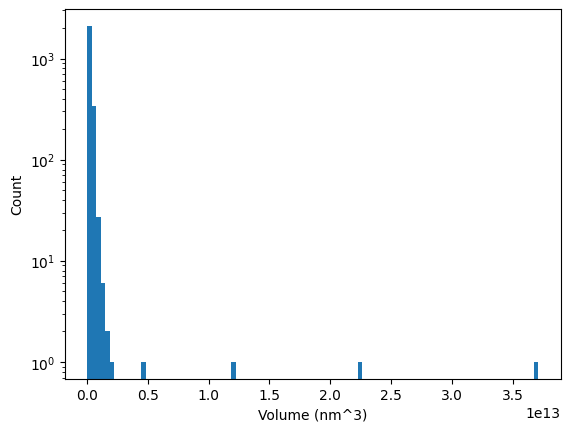

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/nrs/cellmap/ackermand/cellmap/analysisResults/jrc_mus-liver-zon-1/nucleus.csv")
plt.hist(df["Volume (nm^3)"],bins=100)
plt.semilogy()
plt.ylabel('Count')
plt.xlabel('Volume (nm^3)')

In [16]:
import numpy as np
np.sum(df["Volume (nm^3)"]>0.25e13)

4